In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import array_to_latex, plot_state_qsphere, plot_bloch_multivector
from qiskit.extensions import Initialize

TOKEN = ''

from qiskit import transpile
from qiskit.providers.aer import QasmSimulator

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

from IPython.display import display, HTML

In [2]:
# IBMQ.save_account(TOKEN)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Zadanie 1 - rozwiązanie 1

## Oracle (10)

In [3]:
def _switch_oracle(circuit, x):
    if x == 0:
        circuit.x(0)
        circuit.x(1)
    elif x == 1:
        circuit.x(1)
    elif x == 2:
        circuit.x(0)
    elif x == 3:
        pass
    else:
        raise ValueError('Wrong x')

def get_oracle(x=3):
    circuit = QuantumCircuit(3, name='oracle')
    
    _switch_oracle(circuit, x)
    circuit.toffoli(0, 1, 2)
    _switch_oracle(circuit, x)
    
    return circuit

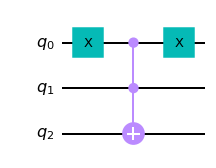

In [4]:
oracle = get_oracle(x=2)
oracle.draw('mpl')

## Grover circuit

In [5]:
def add_grover(circuit, oracle):
    # prepare 1 on y
    circuit.x(2)
    circuit.barrier()
    
    # oracle
    circuit.h([0, 1, 2])
    circuit.append(oracle, [0, 1, 2])
    circuit.barrier()
    
    # inversion
    circuit.h([0, 1])
    circuit.x([0, 1])
    circuit.barrier()
    
    circuit.h(1)
    circuit.cnot(0, 1)
    circuit.h(1)
    circuit.barrier()
    
    circuit.x([0, 1])
    
    circuit.h([0, 1])
    
    return circuit

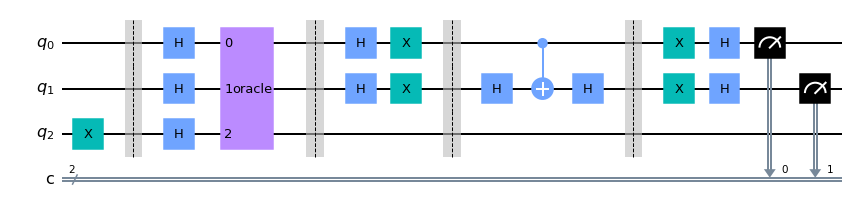

In [6]:
circuit = QuantumCircuit(3, 2)
add_grover(circuit, oracle)
circuit.measure([0, 1], [0, 1])
circuit.draw('mpl')

## Test

In [7]:
backend = QasmSimulator()

circuit_compiled = transpile(circuit, backend, optimization_level=3)
job_sim = backend.run(circuit_compiled, shots=1024)
result_sim = job_sim.result()
sim_counts = result_sim.get_counts(circuit_compiled)
print(sim_counts)

{'10': 1024}


In [9]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

circuit_compiled = transpile(circuit, backend, optimization_level=3)

job_real = backend.run(circuit_compiled, shots=1024)
job_monitor(job_real, interval=1)
result_real = job_real.result()
real_counts = result_real.get_counts()
print(real_counts)

least busy backend:  ibmq_quito
Job Status: job has successfully run
{'00': 146, '01': 54, '10': 766, '11': 58}


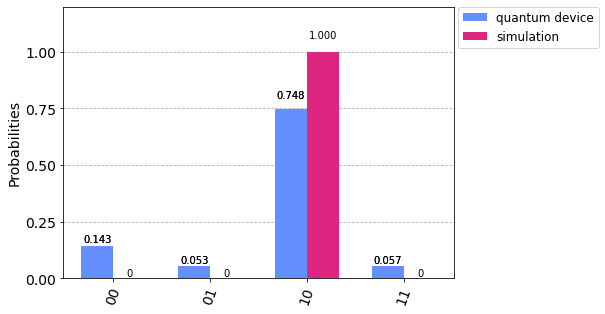

In [10]:
plot_histogram(data=[real_counts, sim_counts], legend=['quantum device', 'simulation'])

# Zadanie 1 - rozwiązanie 2

## Oracle (01)

In [11]:
def get_oracle(x=3):
    circuit = QuantumCircuit(2, name='oracle')
    
    _switch_oracle(circuit, x)
    circuit.cz(0, 1)
    _switch_oracle(circuit, x)
    
    return circuit

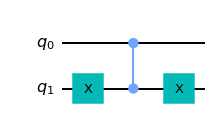

In [12]:
oracle = get_oracle(x=1)
oracle.draw('mpl')

## Grover circuit

In [13]:
def add_grover(circuit, oracle):
    # oracle
    circuit.h([0, 1])
    circuit.append(oracle, [0, 1])
    circuit.barrier()
    
    # inversion
    circuit.h([0, 1])
    circuit.z([0, 1])
    
    circuit.cz(0, 1)
    circuit.h([0, 1])
    
    return circuit

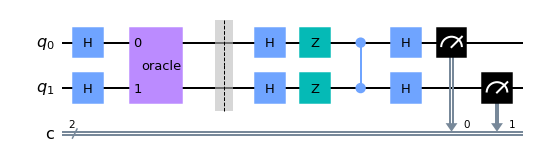

In [14]:
circuit = QuantumCircuit(2, 2)
add_grover(circuit, oracle)
circuit.measure([0, 1], [0, 1])
circuit.draw('mpl')

## Test

In [15]:
backend = QasmSimulator()

circuit_compiled = transpile(circuit, backend, optimization_level=3)
job_sim = backend.run(circuit_compiled, shots=1024)
result_sim = job_sim.result()
sim_counts = result_sim.get_counts(circuit_compiled)
print(sim_counts)

{'01': 1024}


In [18]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

circuit_compiled = transpile(circuit, backend, optimization_level=3)

job_real = backend.run(circuit_compiled, shots=1024)
job_monitor(job_real, interval=1)
result_real = job_real.result()
real_counts = result_real.get_counts()
print(real_counts)

least busy backend:  ibmq_santiago
Job Status: job has successfully run
{'00': 41, '01': 928, '10': 3, '11': 52}


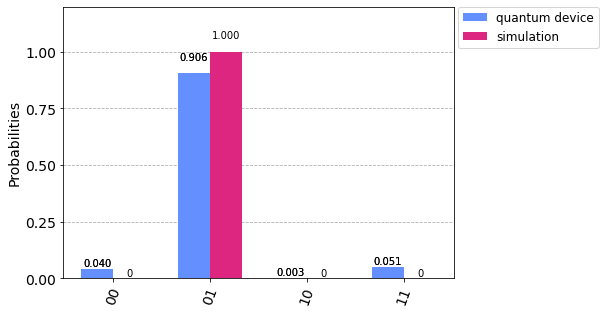

In [19]:
plot_histogram(data=[real_counts, sim_counts], legend=['quantum device', 'simulation'])

# Zadanie 2

In [20]:
N = 6 # n qubits

all_ = list(range(N))
head = N - 1
tail = list(range(N - 1))

## Oracle

In [21]:
def _switch_oracle(circuit, x):
    for i in range(N):
        if x % 2 == 0:
            circuit.x(i)
        x //= 2
        
def get_oracle(x=5):
    circuit = QuantumCircuit(N, name='oracle')
    
    _switch_oracle(circuit, x)
    circuit.barrier()
    
    # controlled z
    circuit.h(head)
    circuit.mcx(tail, head)
    circuit.h(head)
    circuit.barrier()
    
    _switch_oracle(circuit, x)
    
    return circuit

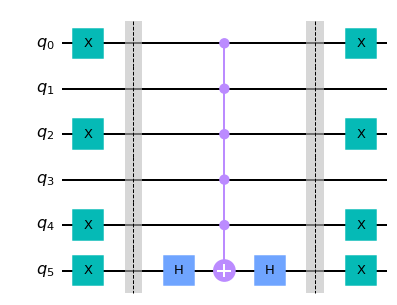

In [22]:
oracle = get_oracle(x=10)
oracle.draw('mpl')

## Grover

In [23]:
def add_grover_iteration(circuit, oracle):
    # oracle
    circuit.append(oracle, all_)
    
    # inversion
    circuit.h(all_)
    circuit.x(all_)
    circuit.barrier()
    
    circuit.h(head)
    circuit.mcx(tail, head) # controlled z
    circuit.h(head)
    circuit.barrier()
    
    circuit.x(all_)
    circuit.h(all_)
    
def get_grover(oracle, n):
    circuit = QuantumCircuit(N)
    circuit.h(all_)
    for _ in range(n):
        add_grover_iteration(circuit, oracle)
        circuit.barrier()
    return circuit

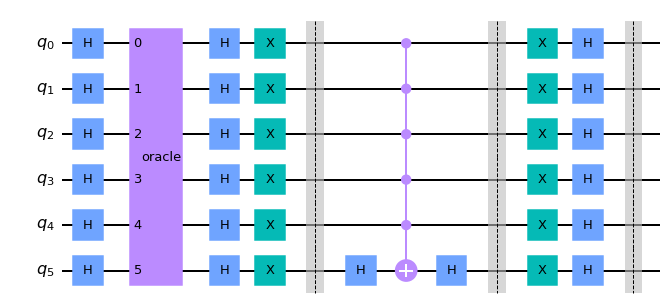

In [24]:
circuit = get_grover(oracle, 1)
circuit.draw('mpl')

## Test: $n \approx \frac{\pi}{4}\sqrt{N}$

In [25]:
n = np.pi / 4 * np.sqrt(2 ** N)
print(f'n = {n:.4f}')

n = 6.2832


In [26]:
def print_amplitudes(circuit, n=N, long=True):
    state = Statevector.from_int(0, 2**n)
    state = state.evolve(circuit)
    i_max = np.argmax(np.abs(state))
    print(f'Max amplitude: {state[int(i_max)]:.3f}')
    if long:
        for i in range(2 ** n):
            basis_state = bin(i).replace('0b', '')
            basis_state = '0' * (n - len(basis_state)) + basis_state
            if i != i_max:
                print(f"{'|' + basis_state + '>':>5}: {state[i]:.3f}")
            else:
                print(f"{'|' + basis_state + '>':>5}: {state[i]:.3f} <----------------------")

In [27]:
for n in range(1, 9):
    print(f'n = {n:2}  ', end='')
    print_amplitudes(get_grover(oracle, n), long=False)

n =  1  Max amplitude: -0.367+0.000j
n =  2  Max amplitude: 0.586-0.000j
n =  3  Max amplitude: -0.769+0.000j
n =  4  Max amplitude: 0.904-0.000j
n =  5  Max amplitude: -0.982+0.000j
n =  6  Max amplitude: 0.998-0.000j
n =  7  Max amplitude: -0.953+0.000j
n =  8  Max amplitude: 0.847-0.000j


In [28]:
for n in range(1, 9):
    display(HTML(f'<h2>n = {n}</h2>'))
    print_amplitudes(get_grover(oracle, n), long=True)

Max amplitude: -0.367+0.000j
|000000>: -0.117+0.000j
|000001>: -0.117+0.000j
|000010>: -0.117+0.000j
|000011>: -0.117+0.000j
|000100>: -0.117+0.000j
|000101>: -0.117+0.000j
|000110>: -0.117+0.000j
|000111>: -0.117+0.000j
|001000>: -0.117+0.000j
|001001>: -0.117+0.000j
|001010>: -0.367+0.000j <----------------------
|001011>: -0.117+0.000j
|001100>: -0.117+0.000j
|001101>: -0.117+0.000j
|001110>: -0.117+0.000j
|001111>: -0.117-0.000j
|010000>: -0.117+0.000j
|010001>: -0.117+0.000j
|010010>: -0.117+0.000j
|010011>: -0.117+0.000j
|010100>: -0.117+0.000j
|010101>: -0.117+0.000j
|010110>: -0.117+0.000j
|010111>: -0.117+0.000j
|011000>: -0.117+0.000j
|011001>: -0.117+0.000j
|011010>: -0.117+0.000j
|011011>: -0.117+0.000j
|011100>: -0.117+0.000j
|011101>: -0.117+0.000j
|011110>: -0.117+0.000j
|011111>: -0.117+0.000j
|100000>: -0.117+0.000j
|100001>: -0.117+0.000j
|100010>: -0.117+0.000j
|100011>: -0.117+0.000j
|100100>: -0.117+0.000j
|100101>: -0.117+0.000j
|100110>: -0.117+0.000j
|100111>: -

Max amplitude: 0.586-0.000j
|000000>: 0.102-0.000j
|000001>: 0.102-0.000j
|000010>: 0.102-0.000j
|000011>: 0.102-0.000j
|000100>: 0.102-0.000j
|000101>: 0.102-0.000j
|000110>: 0.102-0.000j
|000111>: 0.102-0.000j
|001000>: 0.102-0.000j
|001001>: 0.102+0.000j
|001010>: 0.586-0.000j <----------------------
|001011>: 0.102-0.000j
|001100>: 0.102-0.000j
|001101>: 0.102-0.000j
|001110>: 0.102-0.000j
|001111>: 0.102-0.000j
|010000>: 0.102-0.000j
|010001>: 0.102-0.000j
|010010>: 0.102-0.000j
|010011>: 0.102-0.000j
|010100>: 0.102-0.000j
|010101>: 0.102-0.000j
|010110>: 0.102-0.000j
|010111>: 0.102-0.000j
|011000>: 0.102-0.000j
|011001>: 0.102-0.000j
|011010>: 0.102-0.000j
|011011>: 0.102-0.000j
|011100>: 0.102-0.000j
|011101>: 0.102-0.000j
|011110>: 0.102-0.000j
|011111>: 0.102-0.000j
|100000>: 0.102-0.000j
|100001>: 0.102-0.000j
|100010>: 0.102-0.000j
|100011>: 0.102-0.000j
|100100>: 0.102-0.000j
|100101>: 0.102-0.000j
|100110>: 0.102-0.000j
|100111>: 0.102-0.000j
|101000>: 0.102-0.000j
|1010

Max amplitude: -0.769+0.000j
|000000>: -0.081+0.000j
|000001>: -0.081+0.000j
|000010>: -0.081+0.000j
|000011>: -0.081+0.000j
|000100>: -0.081+0.000j
|000101>: -0.081+0.000j
|000110>: -0.081+0.000j
|000111>: -0.081+0.000j
|001000>: -0.081+0.000j
|001001>: -0.081+0.000j
|001010>: -0.769+0.000j <----------------------
|001011>: -0.081+0.000j
|001100>: -0.081+0.000j
|001101>: -0.081+0.000j
|001110>: -0.081+0.000j
|001111>: -0.081+0.000j
|010000>: -0.081+0.000j
|010001>: -0.081+0.000j
|010010>: -0.081+0.000j
|010011>: -0.081+0.000j
|010100>: -0.081+0.000j
|010101>: -0.081+0.000j
|010110>: -0.081+0.000j
|010111>: -0.081+0.000j
|011000>: -0.081+0.000j
|011001>: -0.081+0.000j
|011010>: -0.081+0.000j
|011011>: -0.081+0.000j
|011100>: -0.081+0.000j
|011101>: -0.081+0.000j
|011110>: -0.081+0.000j
|011111>: -0.081+0.000j
|100000>: -0.081+0.000j
|100001>: -0.081+0.000j
|100010>: -0.081+0.000j
|100011>: -0.081+0.000j
|100100>: -0.081+0.000j
|100101>: -0.081+0.000j
|100110>: -0.081+0.000j
|100111>: -

Max amplitude: 0.904-0.000j
|000000>: 0.054-0.000j
|000001>: 0.054-0.000j
|000010>: 0.054-0.000j
|000011>: 0.054-0.000j
|000100>: 0.054-0.000j
|000101>: 0.054-0.000j
|000110>: 0.054-0.000j
|000111>: 0.054-0.000j
|001000>: 0.054-0.000j
|001001>: 0.054-0.000j
|001010>: 0.904-0.000j <----------------------
|001011>: 0.054-0.000j
|001100>: 0.054-0.000j
|001101>: 0.054-0.000j
|001110>: 0.054-0.000j
|001111>: 0.054-0.000j
|010000>: 0.054-0.000j
|010001>: 0.054-0.000j
|010010>: 0.054-0.000j
|010011>: 0.054-0.000j
|010100>: 0.054-0.000j
|010101>: 0.054-0.000j
|010110>: 0.054-0.000j
|010111>: 0.054-0.000j
|011000>: 0.054-0.000j
|011001>: 0.054-0.000j
|011010>: 0.054-0.000j
|011011>: 0.054-0.000j
|011100>: 0.054-0.000j
|011101>: 0.054-0.000j
|011110>: 0.054-0.000j
|011111>: 0.054-0.000j
|100000>: 0.054-0.000j
|100001>: 0.054-0.000j
|100010>: 0.054-0.000j
|100011>: 0.054-0.000j
|100100>: 0.054-0.000j
|100101>: 0.054-0.000j
|100110>: 0.054-0.000j
|100111>: 0.054-0.000j
|101000>: 0.054-0.000j
|1010

Max amplitude: -0.982+0.000j
|000000>: -0.024+0.000j
|000001>: -0.024+0.000j
|000010>: -0.024+0.000j
|000011>: -0.024+0.000j
|000100>: -0.024+0.000j
|000101>: -0.024+0.000j
|000110>: -0.024+0.000j
|000111>: -0.024+0.000j
|001000>: -0.024+0.000j
|001001>: -0.024+0.000j
|001010>: -0.982+0.000j <----------------------
|001011>: -0.024+0.000j
|001100>: -0.024+0.000j
|001101>: -0.024+0.000j
|001110>: -0.024-0.000j
|001111>: -0.024-0.000j
|010000>: -0.024+0.000j
|010001>: -0.024+0.000j
|010010>: -0.024+0.000j
|010011>: -0.024+0.000j
|010100>: -0.024+0.000j
|010101>: -0.024+0.000j
|010110>: -0.024+0.000j
|010111>: -0.024+0.000j
|011000>: -0.024+0.000j
|011001>: -0.024+0.000j
|011010>: -0.024+0.000j
|011011>: -0.024+0.000j
|011100>: -0.024+0.000j
|011101>: -0.024+0.000j
|011110>: -0.024+0.000j
|011111>: -0.024+0.000j
|100000>: -0.024+0.000j
|100001>: -0.024+0.000j
|100010>: -0.024+0.000j
|100011>: -0.024+0.000j
|100100>: -0.024+0.000j
|100101>: -0.024+0.000j
|100110>: -0.024+0.000j
|100111>: -

Max amplitude: 0.998-0.000j
|000000>: -0.007+0.000j
|000001>: -0.007+0.000j
|000010>: -0.007+0.000j
|000011>: -0.007+0.000j
|000100>: -0.007+0.000j
|000101>: -0.007+0.000j
|000110>: -0.007+0.000j
|000111>: -0.007+0.000j
|001000>: -0.007+0.000j
|001001>: -0.007+0.000j
|001010>: 0.998-0.000j <----------------------
|001011>: -0.007+0.000j
|001100>: -0.007+0.000j
|001101>: -0.007-0.000j
|001110>: -0.007-0.000j
|001111>: -0.007-0.000j
|010000>: -0.007+0.000j
|010001>: -0.007+0.000j
|010010>: -0.007-0.000j
|010011>: -0.007+0.000j
|010100>: -0.007-0.000j
|010101>: -0.007+0.000j
|010110>: -0.007-0.000j
|010111>: -0.007-0.000j
|011000>: -0.007+0.000j
|011001>: -0.007+0.000j
|011010>: -0.007+0.000j
|011011>: -0.007-0.000j
|011100>: -0.007+0.000j
|011101>: -0.007-0.000j
|011110>: -0.007+0.000j
|011111>: -0.007-0.000j
|100000>: -0.007+0.000j
|100001>: -0.007+0.000j
|100010>: -0.007+0.000j
|100011>: -0.007+0.000j
|100100>: -0.007+0.000j
|100101>: -0.007+0.000j
|100110>: -0.007+0.000j
|100111>: -0.

Max amplitude: -0.953+0.000j
|000000>: 0.038-0.000j
|000001>: 0.038-0.000j
|000010>: 0.038-0.000j
|000011>: 0.038-0.000j
|000100>: 0.038-0.000j
|000101>: 0.038-0.000j
|000110>: 0.038-0.000j
|000111>: 0.038-0.000j
|001000>: 0.038-0.000j
|001001>: 0.038-0.000j
|001010>: -0.953+0.000j <----------------------
|001011>: 0.038-0.000j
|001100>: 0.038-0.000j
|001101>: 0.038-0.000j
|001110>: 0.038-0.000j
|001111>: 0.038-0.000j
|010000>: 0.038-0.000j
|010001>: 0.038-0.000j
|010010>: 0.038-0.000j
|010011>: 0.038-0.000j
|010100>: 0.038-0.000j
|010101>: 0.038-0.000j
|010110>: 0.038-0.000j
|010111>: 0.038-0.000j
|011000>: 0.038-0.000j
|011001>: 0.038-0.000j
|011010>: 0.038-0.000j
|011011>: 0.038-0.000j
|011100>: 0.038-0.000j
|011101>: 0.038-0.000j
|011110>: 0.038-0.000j
|011111>: 0.038-0.000j
|100000>: 0.038-0.000j
|100001>: 0.038-0.000j
|100010>: 0.038-0.000j
|100011>: 0.038-0.000j
|100100>: 0.038-0.000j
|100101>: 0.038-0.000j
|100110>: 0.038-0.000j
|100111>: 0.038-0.000j
|101000>: 0.038-0.000j
|10

Max amplitude: 0.847-0.000j
|000000>: -0.067+0.000j
|000001>: -0.067+0.000j
|000010>: -0.067+0.000j
|000011>: -0.067+0.000j
|000100>: -0.067+0.000j
|000101>: -0.067+0.000j
|000110>: -0.067+0.000j
|000111>: -0.067+0.000j
|001000>: -0.067+0.000j
|001001>: -0.067+0.000j
|001010>: 0.847-0.000j <----------------------
|001011>: -0.067+0.000j
|001100>: -0.067+0.000j
|001101>: -0.067+0.000j
|001110>: -0.067+0.000j
|001111>: -0.067+0.000j
|010000>: -0.067+0.000j
|010001>: -0.067+0.000j
|010010>: -0.067+0.000j
|010011>: -0.067+0.000j
|010100>: -0.067+0.000j
|010101>: -0.067+0.000j
|010110>: -0.067+0.000j
|010111>: -0.067+0.000j
|011000>: -0.067+0.000j
|011001>: -0.067+0.000j
|011010>: -0.067+0.000j
|011011>: -0.067+0.000j
|011100>: -0.067+0.000j
|011101>: -0.067+0.000j
|011110>: -0.067+0.000j
|011111>: -0.067+0.000j
|100000>: -0.067+0.000j
|100001>: -0.067+0.000j
|100010>: -0.067+0.000j
|100011>: -0.067+0.000j
|100100>: -0.067+0.000j
|100101>: -0.067+0.000j
|100110>: -0.067+0.000j
|100111>: -0.